In [4]:
import numpy as np 
from scipy.integrate import solve_ivp
import jax
import jax.numpy as jnp
from jax import grad, random, vmap
import optax
from kernel_sca import *
from utils import *
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import wandb

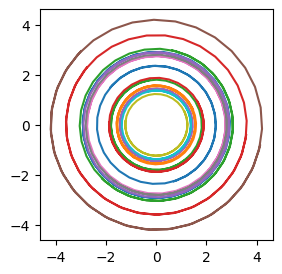

In [5]:
def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]


t_span = (0, 10)                                    # simulate from t=0 to t=10 seconds
t_eval = np.linspace(t_span[0], t_span[1], 50)     # time points where the solution is computed


num_trajectories = 15

seed = 42
np.random.seed(seed) 
initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(num_trajectories, 2))

plt.figure(figsize=(3,3))
for initial_conditions in initial_conditions_list:
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]
    plt.plot(x1, x2, label=f'IC: {np.round(initial_conditions, 2)}')

#Create X ( K = initial condition, N = (x1,x2), T = len(t_eval) )
X = np.zeros((num_trajectories, 2, len(t_eval)))
for i, initial_conditions in enumerate(initial_conditions_list):
    solution = solve_ivp(rotation_system, t_span, initial_conditions, t_eval=t_eval)
    x1 = solution.y[0]
    x2 = solution.y[1]

    X[i, 0, :] = x1
    X[i, 1, :] = x2
X = jnp.array(X)


In [3]:
def K_X_Y_squared_exponential(X, Y, l=1.0, sigma_f=1.0):
    sq_dist = np.sum((X.T[:, np.newaxis, :] - Y.T[np.newaxis, :, :])**2, axis=2)
    return sigma_f**2 * np.exp(-0.5 / l**2 * sq_dist)



(15, 10, 50)


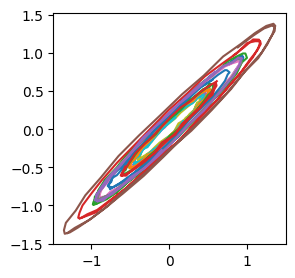

In [6]:
seed = 42
key = random.PRNGKey(seed)
key, subkey = random.split(key)

proj_dims = 10
proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)

X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
print(X.shape)

noise = random.normal(subkey, (X.shape)) 
X += (noise)  /100
X = jnp.array(X)
K, N, T = X.shape

plt.figure(figsize=(3,3))
for i,initial_conditions in enumerate(initial_conditions_list):
    plt.plot(X[i,0,:],X[i,10,:] )


In [4]:
split = 5
X_train = X[split:]
X_test = X[:split]

A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                                                                                        #(N, K*T)

K_A_X = K_X_Y_identity(A, X_train)                                     #(K*T, K, T)

K_A_A = K_X_Y_identity(A, A)

# l = 1
K, N, T = X_train.shape
# K_A_X = np.zeros((K*T, K, T))
# for k in range(K):
#     K_A_X[:,k,:] = K_X_Y_squared_exponential(A, X_train[k], l = l)
# K_A_X = jnp.array(K_A_X)

# K_A_A = jnp.array(K_X_Y_squared_exponential(A, A, l = l))

K_A_A_reshaped = K_A_A.reshape(K,T,K,T)                          #(K,T,K,T)
means = jnp.mean(K_A_A_reshaped, axis=(0, 2), keepdims=True)     #(1, T, 1, T)
K_A_A_tilde = (K_A_A_reshaped - means).reshape(K*T,K*T)          #(K*T,K*T)
P, S, Pt = jnp.linalg.svd(K_A_A_tilde, full_matrices=False)      #P is (K*T, K*T) and S is (K*T,)

In [5]:
d=2
wandb.init(project="SCA-project-toydata-kernel", name="run_1", mode="disabled")
alpha_tilde, ls_loss, ls_S_ratio = optimize(P, S, K_A_X, X_train, d=d, learning_rate=0.01, iterations=500) 
wandb.finish

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Iteration 0, S: 0.005454097408801317, S_ratio: 0.44419729709625244
Iteration 10, S: 0.014858138747513294, S_ratio: 0.46874576807022095
Iteration 20, S: 0.03794197365641594, S_ratio: 0.7498680353164673
Iteration 30, S: 0.09131064265966415, S_ratio: 0.828671395778656
Iteration 40, S: 0.2805076837539673, S_ratio: 0.8493316173553467
Iteration 50, S: 0.7282754778862, S_ratio: 0.6436223387718201
Iteration 60, S: 2.6716580390930176, S_ratio: 0.4523368775844574
Iteration 70, S: 7.708289623260498, S_ratio: 0.3936222493648529
Iteration 80, S: 25.395906448364258, S_ratio: 0.39010414481163025
Iteration 90, S: 72.9215087890625, S_ratio: 0.41896167397499084
Iteration 100, S: 168.55624389648438, S_ratio: 0.39886000752449036
Iteration 110, S: 401.98992919921875, S_ratio: 0.4070450961589813
Iteration 120, S: 395.85540771484375, S_ratio: 0.7672079205513
Iteration 130, S: 557.5678100585938, S_ratio: 0.8205546140670776
Iteration 140, S: 799.3681640625, S_ratio: 0.6696652770042419
Iteration 150, S: 949.426

<function wandb.sdk.wandb_run.finish(exit_code: Optional[int] = None, quiet: Optional[bool] = None) -> None>

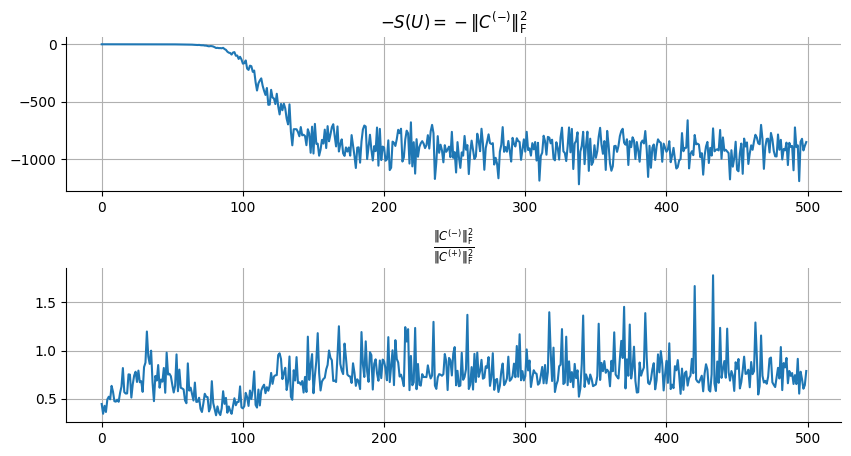

In [6]:
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(ls_loss)
plt.grid()
plt.title(r"$-S(U) = -\|C^{(-)}\|_\mathrm{F}^2$")
plt.gca().spines[['top','right']].set_visible(False)
plt.subplot(212)
plt.plot(ls_S_ratio)
plt.title(r"$\frac{\|C^{(-)}\|_\mathrm{F}^2}{\|C^{(+)}\|_\mathrm{F}^2}$")
plt.gca().spines[['top','right']].set_visible(False)
plt.grid()
plt.subplots_adjust(hspace=0.5)

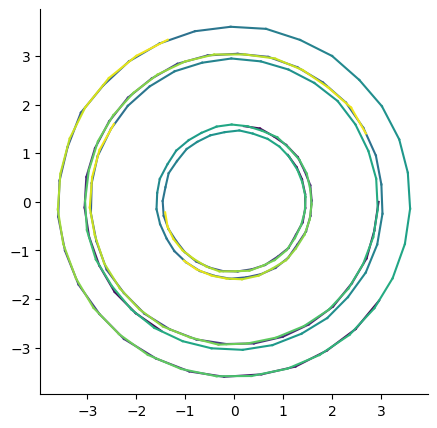

In [7]:
alpha_tilde_QR, _ = jnp.linalg.qr(alpha_tilde) 
alpha = (P / jnp.sqrt(S)) @ alpha_tilde_QR

alpha_reshaped = alpha.reshape(K,T,d)                                           #(K, T, d)
mean = jnp.mean(alpha_reshaped, axis=(0), keepdims=True)                        #(1, T, d)
optimized_alpha_H = (alpha_reshaped - mean).reshape(K*T,d)                      #(K*T,d)

# _, K_test, _ = X_test.shape
# K_A_X_test = np.zeros((K*T, K_test, T))
# for k in range(K_test):
#     K_A_X_test[:,k,:] = K_X_Y_squared_exponential(A, X_test[k], l = l)
# K_A_X_test = jnp.array(K_A_X_test)
K_A_X_test = K_X_Y_identity(A, X_test)                                     #(K*T, K, T)

projection = jnp.einsum('ij,imk->mjk', optimized_alpha_H, K_A_X_test)                #(K*T,d) @ (K*T, K, T) --> (K, d, T)


plot_2D(projection)
#plt.title(f"sca {var_explained(K_A_X, optimized_alpha_H):.2f}")